In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve, ShuffleSplit
from sklearn import tree

In [ ]:
testing = pd.read_csv('/content/gdrive/MyDrive/DSA3101 Group 9/Group Assignment 1/Data/resale(2017).csv')
testing['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '07 TO 09', '04 TO 06', '13 TO 15',
       '28 TO 30', '16 TO 18', '22 TO 24', '19 TO 21', '25 TO 27',
       '34 TO 36', '31 TO 33', '37 TO 39', '40 TO 42', '46 TO 48',
       '43 TO 45', '49 TO 51'], dtype=object)

In [ ]:
resale = pd.read_csv('/content/gdrive/MyDrive/DSA3101 Group 9/Group Assignment 1/Data/resale(2017).csv')

# only choosing flats with 3/4/5 rooms and executive
resale = resale.loc[resale['flat_type'].isin(['3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE'])]

resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,remaining_years,storey_coded,district,Region,addr,lat,long,nearby_mrt,nearby_park,nearby_school,nearby_hawker,nearby_supermarket,count_nearby_mrt,count_nearby_hawker,count_nearby_park,count_nearby_school,count_nearby_supermarket
9,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,new generation,1978-01-01,250000.0,14245 days,59.932784,1,20,RCR,108 ANG MO KIO AVE 4,1.370966,103.838202,[],"['St. Nicholas View Playground', 'Ellington Sq...","['ANG MO KIO PRIMARY SCHOOL', 'ANG MO KIO SECO...",['Ang Mo Kio Ave 1 Blk 226D (Kebun Baru Market...,"['SHENG SIONG SUPERMARKET PTE LTD ', 'SHENG SI...",0,4,7,7,7
10,2017-02-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,07 TO 09,67.0,new generation,1978-01-01,295000.0,14276 days,59.847909,3,20,RCR,108 ANG MO KIO AVE 4,1.370966,103.838202,[],"['St. Nicholas View Playground', 'Ellington Sq...","['ANG MO KIO PRIMARY SCHOOL', 'ANG MO KIO SECO...",['Ang Mo Kio Ave 1 Blk 226D (Kebun Baru Market...,"['SHENG SIONG SUPERMARKET PTE LTD ', 'SHENG SI...",0,4,7,7,7
11,2017-11-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,10 TO 12,67.0,new generation,1978-01-01,288000.0,14549 days,59.100461,0,20,RCR,108 ANG MO KIO AVE 4,1.370966,103.838202,[],"['St. Nicholas View Playground', 'Ellington Sq...","['ANG MO KIO PRIMARY SCHOOL', 'ANG MO KIO SECO...",['Ang Mo Kio Ave 1 Blk 226D (Kebun Baru Market...,"['SHENG SIONG SUPERMARKET PTE LTD ', 'SHENG SI...",0,4,7,7,7
12,2017-11-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,10 TO 12,67.0,new generation,1978-01-01,298000.0,14549 days,59.100461,0,20,RCR,108 ANG MO KIO AVE 4,1.370966,103.838202,[],"['St. Nicholas View Playground', 'Ellington Sq...","['ANG MO KIO PRIMARY SCHOOL', 'ANG MO KIO SECO...",['Ang Mo Kio Ave 1 Blk 226D (Kebun Baru Market...,"['SHENG SIONG SUPERMARKET PTE LTD ', 'SHENG SI...",0,4,7,7,7
13,2018-06-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,82.0,new generation,1978-01-01,345000.0,14761 days,58.520024,1,20,RCR,108 ANG MO KIO AVE 4,1.370966,103.838202,[],"['St. Nicholas View Playground', 'Ellington Sq...","['ANG MO KIO PRIMARY SCHOOL', 'ANG MO KIO SECO...",['Ang Mo Kio Ave 1 Blk 226D (Kebun Baru Market...,"['SHENG SIONG SUPERMARKET PTE LTD ', 'SHENG SI...",0,4,7,7,7


In [ ]:
# exclude variables 
resale.drop(columns = ['block', 'street_name', 'lease_commence_date', 'month', 'storey_range', 'addr', 'remaining_lease',
                      'nearby_mrt', 'nearby_hawker', 'nearby_park', 'nearby_school', 'nearby_supermarket', 'district', 'count_nearby_supermarket'], 
            inplace = True)

In [ ]:
# describes the continuous variables
resale.describe()

,floor_area_sqm,resale_price,remaining_years,storey_coded,lat,long,count_nearby_mrt,count_nearby_hawker,count_nearby_park,count_nearby_school
count,103913.000000,1.039130e+05,103913.000000,103913.000000,103913.000000,103913.000000,103913.000000,103913.000000,103913.000000,103913.000000
mean,98.611997,4.558951e+05,74.308537,2.374881,1.367412,103.841437,1.179025,1.541328,2.049561,5.500852
std,23.411769,1.556076e+05,13.068226,2.171481,0.042531,0.071509,1.154231,1.572756,2.224614,2.340308
min,51.000000,1.400000e+05,44.017331,0.000000,1.270380,103.685228,0.000000,0.000000,0.000000,0.000000
25%,84.000000,3.430000e+05,63.935604,1.000000,1.337133,103.778927,0.000000,1.000000,0.000000,4.000000
50%,95.000000,4.250000e+05,74.435478,2.000000,1.367032,103.846887,1.000000,1.000000,1.000000,5.000000
75%,113.000000,5.350000e+05,84.100290,3.000000,1.395002,103.899748,2.000000,2.000000,3.000000,7.000000
max,249.000000,1.268000e+06,97.351759,16.000000,1.457071,103.988093,14.000000,9.000000,15.000000,15.000000


In [ ]:
# express cols with categorical data in factors
cat_col = ['town', 'flat_type', 'Region', 'flat_model']

for col in cat_col:
    resale['ft_' + col] = pd.factorize(resale[col], sort = True)[0]

resale.head()

,town,flat_type,floor_area_sqm,flat_model,resale_price,remaining_years,storey_coded,Region,lat,long,count_nearby_mrt,count_nearby_hawker,count_nearby_park,count_nearby_school,ft_town,ft_flat_type,ft_Region,ft_flat_model
9,ANG MO KIO,3 ROOM,67.0,new generation,250000.0,59.932784,1,RCR,1.370966,103.838202,0,4,7,7,0,0,2,9
10,ANG MO KIO,3 ROOM,67.0,new generation,295000.0,59.847909,3,RCR,1.370966,103.838202,0,4,7,7,0,0,2,9
11,ANG MO KIO,3 ROOM,67.0,new generation,288000.0,59.100461,0,RCR,1.370966,103.838202,0,4,7,7,0,0,2,9
12,ANG MO KIO,3 ROOM,67.0,new generation,298000.0,59.100461,0,RCR,1.370966,103.838202,0,4,7,7,0,0,2,9
13,ANG MO KIO,3 ROOM,82.0,new generation,345000.0,58.520024,1,RCR,1.370966,103.838202,0,4,7,7,0,0,2,9


In [ ]:
# showing each categorical levels and their representation
for col in cat_col:
    data = {}
    data[col] = resale[col].unique()
    data['ft_' + col] = resale['ft_' + col].unique()
    display(pd.DataFrame(data)) 

,town,ft_town
0,ANG MO KIO,0
1,BEDOK,1
2,BISHAN,2
3,BUKIT BATOK,3
4,BUKIT MERAH,4
5,BUKIT PANJANG,5
6,BUKIT TIMAH,6
7,CENTRAL AREA,7
8,CHOA CHU KANG,8
9,CLEMENTI,9


,flat_type,ft_flat_type
0,3 ROOM,0
1,4 ROOM,1
2,EXECUTIVE,3
3,5 ROOM,2


,Region,ft_Region
0,RCR,2
1,OCR,1
2,CCR,0


,flat_model,ft_flat_model
0,new generation,9
1,adjoined flat,0
2,dbss,2
3,standard,14
4,improved,3
5,model a,6
6,apartment,1
7,simplified,13
8,premium apartment,10
9,model a-maisonette,7


In [ ]:
# removing uncleaned categorical columns
resale.drop(columns = cat_col, inplace = True)

# separate into predictor and target response
target_y = resale['resale_price']
resale.drop(columns = ['resale_price'], inplace = True)

resale.head()

,floor_area_sqm,remaining_years,storey_coded,lat,long,count_nearby_mrt,count_nearby_hawker,count_nearby_park,count_nearby_school,ft_town,ft_flat_type,ft_Region,ft_flat_model
9,67.0,59.932784,1,1.370966,103.838202,0,4,7,7,0,0,2,9
10,67.0,59.847909,3,1.370966,103.838202,0,4,7,7,0,0,2,9
11,67.0,59.100461,0,1.370966,103.838202,0,4,7,7,0,0,2,9
12,67.0,59.100461,0,1.370966,103.838202,0,4,7,7,0,0,2,9
13,82.0,58.520024,1,1.370966,103.838202,0,4,7,7,0,0,2,9


In [ ]:
# split into train, test, validation sets
train_X, test_data, train_Y, test_y = train_test_split(resale, target_y, test_size = 0.2, random_state = 1)

train_data, val_data, train_y, val_y = train_test_split(train_X, train_Y, test_size = 0.25, random_state = 1)

print("Train dataset has {} resale houses.".format(len(train_data)))
print("Validation dataset has {} resale houses.".format(len(val_data)))
print("Test dataset has {} resale houses.".format(len(test_data)))
print("Total = {} houses.".format(len(resale)))

Train dataset has 62347 resale houses.
Validation dataset has 20783 resale houses.
Test dataset has 20783 resale houses.
Total = 103913 houses.


In [ ]:
train_data.head()

,floor_area_sqm,remaining_years,storey_coded,lat,long,count_nearby_mrt,count_nearby_hawker,count_nearby_park,count_nearby_school,ft_town,ft_flat_type,ft_Region,ft_flat_model
34829,105.0,71.018570,2,1.371669,103.961764,0,0,0,6,16,1,1,6
99775,92.0,93.099790,4,1.387625,103.758331,0,1,1,8,5,1,1,6
70419,90.0,85.354251,4,1.383601,103.895942,2,1,1,8,20,1,1,10
59484,67.0,53.098968,1,1.333900,103.848855,2,6,1,5,23,0,2,3
57693,65.0,55.604153,5,1.307556,103.794444,4,6,6,0,18,0,2,3


**XGBoost Model**

1. Training the XGBoost model on the train dataset
2. Predicting resale price on train and test dataset
3. Plot of percentange difference between actual and predicted resale price on the test dataset.
4. Accuracy metrics to evaluate the model, using R^2 score, MAPE, MAE and MSE.

In [ ]:
xgb_model = xgb.XGBRegressor(#objective = "reg:squarederror", 
                             reg_alpha = 0.05,
                             gamma = 0.5,
                             learning_rate = 0.01,
                             max_depth = 5,
                             min_child_weight = 3,
                             subsample = 0.9,
                             colsample_bytree = 0.6,
                             random_state = 2019,  
                             n_estimators = 1000
                            )
#training the model                    
xgb_model.fit(train_data,
              train_y,
              eval_set = [(train_data, train_y), (val_data, val_y)],
              eval_metric = ['mae'],
              early_stopping_rounds = 500
             )

[07:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:450969	validation_1-mae:450948
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 500 rounds.
[1]	validation_0-mae:446468	validation_1-mae:446452
[2]	validation_0-mae:442005	validation_1-mae:441990
[3]	validation_0-mae:437592	validation_1-mae:437581
[4]	validation_0-mae:433215	validation_1-mae:433212
[5]	validation_0-mae:428892	validation_1-mae:428886
[6]	validation_0-mae:424604	validation_1-mae:424609
[7]	validation_0-mae:420360	validation_1-mae:420374
[8]	validation_0-mae:416157	validation_1-mae:416177
[9]	validation_0-mae:412002	validation_1-mae:412018
[10]	validation_0-mae:407882	validation_1-mae:407898
[11]	validation_0-mae:403808	validation_1-mae:403834
[12]	validation_0-mae:399773	validation_1-mae:399801
[13]	validation_0-mae:395778	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=2019,
             reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

In [ ]:
# predicting resale price on test and train dataset
test_pred = xgb_model.predict(test_data)
train_pred = xgb_model.predict(train_data)

tab = {'Prediction' : test_pred,
       'Actual' : test_y, 
       'Difference' : (test_pred - test_y),
       'Percentage Difference' : ((test_pred - test_y)/ test_y) * 100}
df_res = pd.DataFrame(tab)
display(df_res)

,Prediction,Actual,Difference,Percentage Difference
82259,379003.62500,369500.0,9503.62500,2.572023
70383,348790.37500,365000.0,-16209.62500,-4.440993
54975,682179.68750,725000.0,-42820.31250,-5.906250
64863,289016.62500,308000.0,-18983.37500,-6.163433
23225,335702.06250,330000.0,5702.06250,1.727898
...,...,...,...,...
97359,435942.81250,420000.0,15942.81250,3.795908
89572,344337.62500,322000.0,22337.62500,6.937151
31827,847151.18750,845000.0,2151.18750,0.254578
77376,541321.62500,520000.0,21321.62500,4.100313


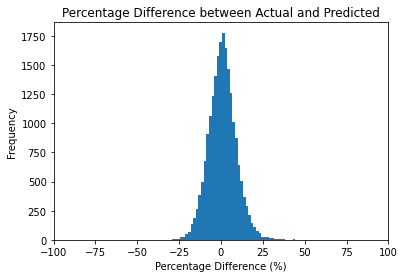

In [ ]:
plt.hist(df_res['Percentage Difference'], bins = 50)
plt.xlim(-100, 100)

plt.xlabel("Percentage Difference (%)")
plt.ylabel("Frequency")
_ = plt.title("Percentage Difference between Actual and Predicted")
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# R^2 score
print('r2 score for test: ', r2_score(test_y, test_pred))
print('r2 score for train: ', r2_score(train_y, train_pred))

# mean absolute error
print('mae for test: ', mean_absolute_error(test_y, test_pred))
print('mae for train: ', mean_absolute_error(train_y, train_pred))

# mean absolute percentage error
print('mape for test: ', mean_absolute_percentage_error(test_y, test_pred), '%')
print('mape for train: ', mean_absolute_percentage_error(train_y, train_pred), '%')

# mean square error
print('mse for test: ', mean_squared_error(test_y, test_pred))
print('mse for train: ', mean_squared_error(train_y, train_pred))

r2 score for test:  0.9391075595278607
r2 score for train:  0.9419613647609983
mae for test:  28740.765237062744
mae for train:  28098.117638138163
mape for test:  6.424507676008684 %
mape for train:  6.314195252955781 %
mse for test:  1492684848.547682
mse for train:  1401434919.6507201


In [ ]:
last = {
    "Data " : ['Test','Train'],
    'R2 Score' : [0.940, 0.942],
    'MAPE' : ['6.410%', '6.307%'],
    'MAE' : [28740.765, 28098.118]
}

display(pd.DataFrame(last))

,Data,R2 Score,MAPE,MAE
0,Test,0.940,6.410%,28740.765
1,Train,0.942,6.307%,28098.118


**Evaluating our XGBoost model**
1. Plot of feature importance in the XGboost model
2. Plot of the tree
3. Predicting duplicated test on the 2 most influencing feature, Region and Flat type.

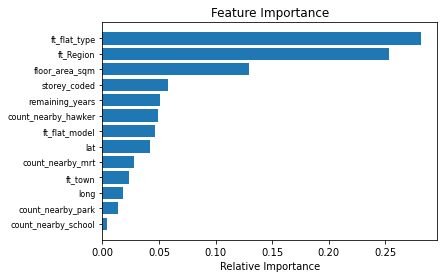

In [ ]:
# Calculate feature importances, then sort in descending order
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [train_data.columns[i] for i in indices]


# Barplot: Add bars
plt.barh(range(len(train_data.columns), 0, -1), importances[indices])
plt.yticks(range(len(train_data.columns), 0, -1), names, fontsize = 8)
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
plt.show()

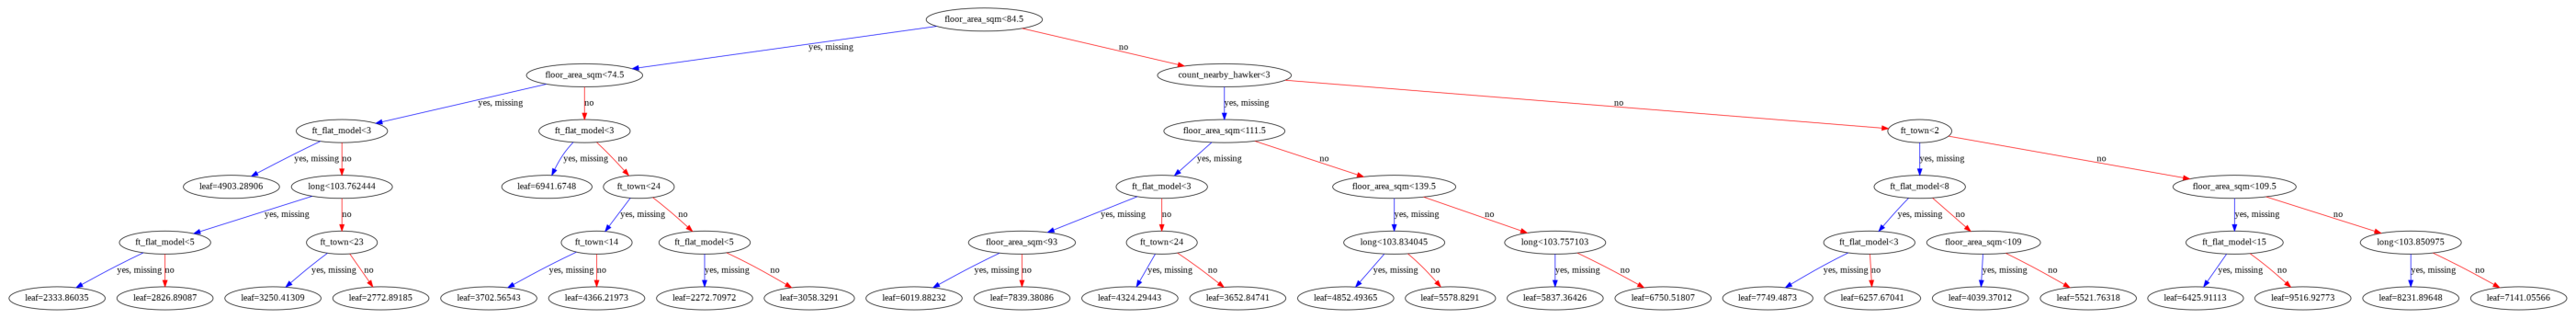

In [ ]:
#plotting the tree
xgb.plot_tree(xgb_model)
plt.rcParams['figure.figsize'] = [20, 100]
plt.show()

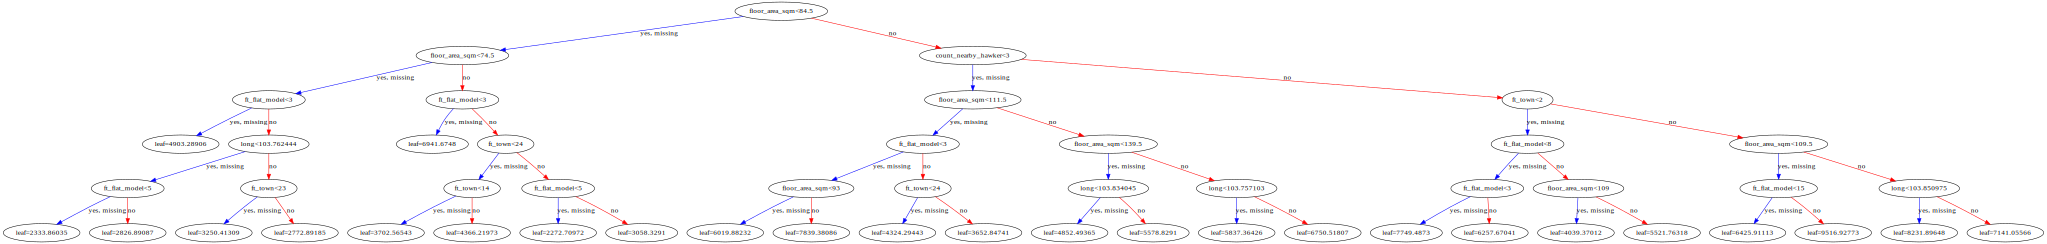

In [ ]:
image = xgb.to_graphviz(xgb_model)
image

**Extra Testing**

We attempt to make predictions on duplicated test sets to predict the value of resale prices while only changing a variable. Clearly from the tests below, we are unable to interpret exactly the relationship between attributes like Flat type and the resale price, because XGBoost is trained in an ensemble manner which progressively updates the training instances and error during its built of the tree to take into account for the underlying factors. Hence, we unable to intepret it like a linear case.

In [ ]:
# Predicting duplicated test on Region

aRCR = test_data.iloc[2:3]
aCCR = aRCR.copy()
aCCR['ft_Region'] = 0
aOCR = aRCR.copy()
aOCR['ft_Region'] = 1
new = pd.concat([aCCR, aRCR, aOCR])
new['predicted price'] = xgb_model.predict(new)

new.drop(columns = ['lat', 'long',	'count_nearby_mrt',	'count_nearby_hawker',	'count_nearby_park',	'count_nearby_school',	'ft_town','ft_flat_model'], inplace = True)

new.columns = ['Floor_area_sqm',	'Remaining Years',	'Storey Range',	'Flat Type',	'Region',	'Predicted Price']
new['Storey Range'] = ['7 TO 9', '7 TO 9', '7 TO 9']
new['Region'] = ['CCR', 'RCR', 'OCR']
new['Flat Type'] = ['4 ROOM', '4 ROOM', '4 ROOM']

new

,Floor_area_sqm,Remaining Years,Storey Range,Flat Type,Region,Predicted Price
54975,127.0,63.847991,7 TO 9,4 ROOM,CCR,764194.1250
54975,127.0,63.847991,7 TO 9,4 ROOM,RCR,682179.6875
54975,127.0,63.847991,7 TO 9,4 ROOM,OCR,568648.7500


In [ ]:
# Predicting duplicated test on Flat Type

a5ROOM = test_data.iloc[2:3]
a3ROOM = a5ROOM.copy()
a3ROOM['ft_flat_type'] = 0
a4ROOM = a5ROOM.copy()
a4ROOM['ft_flat_type'] = 1
aEXECUTIVE = a5ROOM.copy()
aEXECUTIVE['ft_flat_type'] = 3
new = pd.concat([aEXECUTIVE, a5ROOM, a4ROOM, a3ROOM])
new['predicted price'] = [str(i) for i in xgb_model.predict(new).round(1)]

new.drop(columns = ['lat', 'long',	'count_nearby_mrt',	'count_nearby_hawker',	'count_nearby_park',	'count_nearby_school',	'ft_town','ft_flat_model'], inplace = True)


new.columns = ['Floor_area_sqm',	'Remaining Years',	'Storey Range',	'Flat Type',	'Region',	'Predicted Price']
new['Storey Range'] = ['7 TO 9', '7 TO 9', '7 TO 9', '7 TO 9' ]
new['Region'] = ['RCR', 'RCR', 'RCR', 'RCR']
new['Flat Type'] = ['EXECUTIVE', '5 ROOM', '4 ROOM', '3 ROOM']

new

,Floor_area_sqm,Remaining Years,Storey Range,Flat Type,Region,Predicted Price
54975,127.0,63.847991,7 TO 9,EXECUTIVE,RCR,715638.6
54975,127.0,63.847991,7 TO 9,5 ROOM,RCR,682179.7
54975,127.0,63.847991,7 TO 9,4 ROOM,RCR,585750.0
54975,127.0,63.847991,7 TO 9,3 ROOM,RCR,535336.6


In [ ]:
# Predicting another duplicated test on Flat Type

a5ROOM = test_data.iloc[9:10]
a3ROOM = a5ROOM.copy()
a3ROOM['ft_flat_type'] = 0
a4ROOM = a5ROOM.copy()
a4ROOM['ft_flat_type'] = 1
aEXECUTIVE = a5ROOM.copy()
aEXECUTIVE['ft_flat_type'] = 3
new = pd.concat([aEXECUTIVE, a5ROOM, a4ROOM, a3ROOM])
new['predicted price'] = [str(i) for i in xgb_model.predict(new).round(1)]

new.drop(columns = ['lat', 'long',	'count_nearby_mrt',	'count_nearby_hawker',	'count_nearby_park',	'count_nearby_school',	'ft_town','ft_flat_model'], inplace = True)

new.columns = ['Floor_area_sqm',	'Remaining Years',	'Storey Range',	'Flat Type',	'Region',	'Predicted Price']
new['Storey Range'] = ['7 TO 9', '7 TO 9', '7 TO 9', '7 TO 9' ]
new['Region'] = ['RCR', 'RCR', 'RCR', 'RCR']
new['Flat Type'] = ['EXECUTIVE', '5 ROOM', '4 ROOM', '3 ROOM']

new

,Floor_area_sqm,Remaining Years,Storey Range,Flat Type,Region,Predicted Price
4270,107.0,90.687694,7 TO 9,EXECUTIVE,RCR,1074355.4
4270,107.0,90.687694,7 TO 9,5 ROOM,RCR,1076473.5
4270,107.0,90.687694,7 TO 9,4 ROOM,RCR,1013358.4
4270,107.0,90.687694,7 TO 9,3 ROOM,RCR,932677.2


**Tuning Hyperparameters**

We tune the hyperparameters using RandomizedSearchCV() and prune our tree the find the best max_depth that is sufficiently small to prevent overfitting of the data. 


In [ ]:
### Tuning hyperparameters
# 1. GridsearchCV()
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# 2. RandomizedSearchCV() 
# https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58


# Create XGB Classifier object
xgb_reg = xgb.XGBRegressor()

# Create parameter grid
parameters = {"learning_rate": [0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.5, 1, 2],
               "max_depth": [6, 7, 8, 9, 10],
               "colsample_bytree": [i/10.0 for i in range(6,10)],
               "subsample": [i/10.0 for i in range(6,10)],
               'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
               "min_child_weight": [1, 2, 3],
               "n_estimators": [500, 800, 1000, 1200]}

from sklearn.model_selection import RandomizedSearchCV
# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_reg, param_distributions = parameters, scoring = "neg_mean_squared_error",
                             cv = 10, verbose = 3, random_state = 40 )

# Fit the model
model_xgboost = xgb_rscv.fit(train_data, train_y)

In [ ]:
# Model best estimators
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

In [ ]:
# Prune the RandomForest Tree on the max_depth parameter, on 'mse'
# https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_validation_curve.html

regressor = xgb.XGBRegressor(#objective = "reg:squarederror", 
                             reg_alpha = 0.05,
                             gamma = 0.5,
                             learning_rate = 0.01,
                             min_child_weight = 3,
                             subsample = 0.9,
                             colsample_bytree = 0.6,
                             random_state = 2019,  
                             n_estimators = 800
                            )

max_depth = [1,3,5,7,9,11,13,15]
train_scores, test_scores = validation_curve(regressor, train_data, train_y, param_name = "max_depth",
                                             param_range = max_depth, cv = 3, scoring = "neg_mean_absolute_error")

train_errors, test_errors = -train_scores, -test_scores

[05:55:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

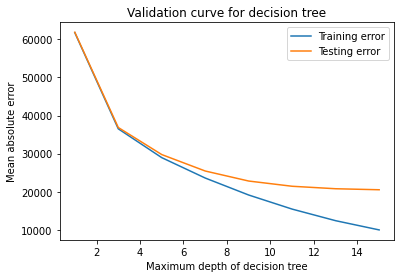

In [ ]:
# Best Max depth = 5
plt.plot(max_depth, train_errors.mean(axis = 1), label = "Training error")
plt.plot(max_depth, test_errors.mean(axis = 1), label = "Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error")
_ = plt.title("Validation curve for decision tree")